In [1]:
using PotentialFlow

In [2]:
using Plots

clibrary(:colorbrewer)
default(clim = (-0.05, 0.05), markerstrokealpha = 0, markersize = 3, grid = false, 
     legend = false, colorbar = :right, colorbar_title = "\$\\Gamma\$")

# Set Up Functions for Potential Flow Constraints

In [3]:
function compute_ẋ!(ẋ, x, t)
    plate, ambient_sys = x
    motion = ẋ[1]
    motion.ċ, motion.c̈, motion.α̇ = motion.kin(t)
    
    Plates.enforce_no_flow_through!(plate, motion, ambient_sys, t)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x, t)
end

compute_ẋ! (generic function with 1 method)

In [4]:
function shed_new_vorticity!(blobs, plate, motion, t, lesp = 0.0, tesp = 0.0)
    z₊ = (blobs[end-1].z + 2plate.zs[end])/3
    z₋ = (blobs[end].z + 2plate.zs[1])/3
    
    blob₊ = Vortex.Blob(z₊, 1.0, δ)
    blob₋ = Vortex.Blob(z₋, 1.0, δ)
    Plates.enforce_no_flow_through!(plate, motion, blobs, t)
    
    Γ₊, Γ₋, _, _ = Plates.vorticity_flux!(plate, blob₊, blob₋, t, lesp, tesp);
    
    push!(blobs, Vortex.Blob(z₊, Γ₊, blobs[1].δ), Vortex.Blob(z₋, Γ₋, blobs[1].δ))
end

shed_new_vorticity! (generic function with 3 methods)

# Set Up Kinematics Functions

### See Viscous Flow examples for how to switch between square/triangle waves and sinusoidal pitch-heaving flapping motions

In [5]:
struct TriangleWave <: RigidBodyMotions.Profile
    w::Float64
    round_factor::Float64
end

(T::TriangleWave)(t) = 1/(1-2/pi*acos(1-T.round_factor))*(1-2/pi*acos((1-T.round_factor)*sin(T.w*t - pi/2)))

In [6]:
struct SquareWave <: RigidBodyMotions.Profile
    w::Float64
    round_factor::Float64
end

(s::SquareWave)(t) = 1/atan(1/s.round_factor)*atan(sin(s.w*t)/s.round_factor)

In [7]:
struct PitchHeaveTest <: Kinematics
    "Freestream velocity"
    U₀::Float64

    "Axis of pitch rotation, relative to the plate centroid"
    a::Float64

    "Reduced frequency ``K = \\frac{\\Omega c}{2U_0}``"
    K::Float64

    "Phase lag of pitch to heave (in radians)"
    ϕ::Float64

    "Mean angle of attack"
    α₀::Float64

    "Amplitude of pitching"
    Δα::Float64

    "Amplitude of translational heaving"
    A::Float64
    
    "Sinusoidal nature of pitching/heaving"
    delta_pitch::Float64
    delta_heave::Float64

    Y::RigidBodyMotions.Profile
    Ẏ::RigidBodyMotions.Profile
    Ÿ::RigidBodyMotions.Profile

    α::RigidBodyMotions.Profile
    α̇::RigidBodyMotions.Profile
    α̈::RigidBodyMotions.Profile
    
end

In [8]:
function PitchHeaveTest(U₀, a, K, ϕ, α₀, α_start, Δα, A)
    p = A*RigidBodyMotions.Sinusoid(2K)
    ṗ = d_dt(p)
    p̈ = d_dt(ṗ)
    α = RigidBodyMotions.ConstantProfile(α₀) + Δα*(RigidBodyMotions.Sinusoid(2K) >> (ϕ/(2K))) + RigidBodyMotions.ConstantProfile(α_start)
    α̇ = d_dt(α)
    α̈ = d_dt(α̇)
    PitchHeaveTest(U₀, a, K, ϕ, α₀, Δα, A, 1, 1, p, ṗ, p̈, α, α̇, α̈)
end

PitchHeaveTest

In [9]:
function PitchHeaveTest(U₀, a, K, ϕ, α₀, α_start, Δα, A, delta_pitch, delta_heave)
    p = A*TriangleWave(2K, delta_heave)
    ṗ = d_dt(p)
    p̈ = d_dt(ṗ)
    α = RigidBodyMotions.ConstantProfile(α₀) + Δα*(SquareWave(2K, delta_pitch) >> (ϕ/(2K))) + RigidBodyMotions.ConstantProfile(α_start)
    α̇ = d_dt(α)
    α̈ = d_dt(α̇)
    PitchHeaveTest(U₀, a, K, ϕ, α₀, Δα, A, delta_pitch, delta_heave, p, ṗ, p̈, α, α̇, α̈)
end

PitchHeaveTest

In [10]:
function (p::PitchHeaveTest)(t)
    α = p.α(t)
    α̇ = p.α̇(t)
    α̈ = p.α̈(t)

    c = p.U₀*t + im*p.Y(t) - p.a*exp(im*α)
    ċ = p.U₀ + im*p.Ẏ(t) - p.a*im*α*exp(im*α)*α̇ 
    c̈ = im*p.Ÿ(t) - p.a*im*α̇ *exp(im*α)*α̇  + p.a*α^2*exp(im*α)*α̇ ^2 - p.a*im*α*exp(im*α)*α̈ 

    # return c, ċ, c̈, α, α̇, α̈
    return ċ, c̈, α̇, α̈    # to work out with RigidBodyMotions in Potential Flow, edit if this doesn't work
    
end

# Setting Up Body, Environment, and Solver

In [11]:
U₀ = 0    # Translation velocity
a  = 0.5  # Pitching axis (leading edge)
K = π*1.0/2   # Pitch rate
α₀ = 0.0  # Center Angle
α_start = 0; # Starting Angle
t₀ = 0.0  # Nominal starting time
Δα = π*30/180  # Total angle change
ϕ = -pi/2 # Phase lag between the triangle/square motions
A = 0.5  # amplitude/chord

oscil = PitchHeaveTest(U₀,a,K,ϕ,α₀,α_start,Δα,A)
motion = RigidBodyMotion(oscil)

Rigid Body Motion:
  ċ = 0.0 + 1.57im
  c̈ = -0.68 + 1.17im
  α̇ = 0.0
  α̈ = -5.17
  PitchHeaveTest(0.0, 0.5, 1.5707963267948966, -1.5707963267948966, 0.0, 0.5235987755982988, 0.5, 1.0, 1.0, 0.5 × (Sinusoid (ω = 3.14)), d/dt (0.5 × (Sinusoid (ω = 3.14))), d/dt (d/dt (0.5 × (Sinusoid (ω = 3.14)))), AddedProfiles:
  Constant (0.0)
  0.5235987755982988 × (Sinusoid (ω = 3.14) >> -0.5)
  Constant (0)
, d/dt (AddedProfiles:
  Constant (0.0)
  0.5235987755982988 × (Sinusoid (ω = 3.14) >> -0.5)
  Constant (0)
), d/dt (d/dt (AddedProfiles:
  Constant (0.0)
  0.5235987755982988 × (Sinusoid (ω = 3.14) >> -0.5)
  Constant (0)
)))

In [34]:
N = 128
L = 1.0 # length of plate
println(oscil)
plate = Plate(N, L, zero(ComplexF64), oscil.α(0))

Δt = 1e-2

δ = 0.01
lesp = 0.6;
tesp = 0.0

Δz₀ = im*3Δt*exp(im*plate.α)
z₋, z₊ = plate.zs[[1,N]]

blobs = Vortex.Blob.(Δz₀ .+ [z₊, z₋], 1.0, δ)

Plates.enforce_no_flow_through!(plate, motion, (), 0)
Γ₊, Γ₋, _, _ = Plates.vorticity_flux!(plate, blobs[1], blobs[2], 0.0, lesp, tesp);

blobs = Vortex.Blob.(Δz₀ .+ [z₊, z₋], [Γ₊, Γ₋], δ)

sys₀ = (plate, blobs)

sys = deepcopy(sys₀)
sys₊ = deepcopy(sys₀) # Used for storage during time-marching
ẋs = (motion, allocate_velocity(blobs))

forces = ComplexF64[];

PitchHeaveTest(0.0, 0.5, 1.5707963267948966, -1.5707963267948966, 0.0, 0.5235987755982988, 0.5, 1.0, 1.0, 0.5 × (Sinusoid (ω = 3.14)), d/dt (0.5 × (Sinusoid (ω = 3.14))), d/dt (d/dt (0.5 × (Sinusoid (ω = 3.14)))), AddedProfiles:
  Constant (0.0)
  0.5235987755982988 × (Sinusoid (ω = 3.14) >> -0.5)
  Constant (0)
, d/dt (AddedProfiles:
  Constant (0.0)
  0.5235987755982988 × (Sinusoid (ω = 3.14) >> -0.5)
  Constant (0)
), d/dt (d/dt (AddedProfiles:
  Constant (0.0)
  0.5235987755982988 × (Sinusoid (ω = 3.14) >> -0.5)
  Constant (0)
)))


# Running the Solver

In [35]:
T = 0.0:Δt:10.0

systems = Tuple{Plate,Array{PotentialFlow.Blobs.Blob{Float64},1}}[];

for t in T
    
    plate, ambient_ω = sys
    motion, ambient_u = ẋs

    resize!(sys₊[2], length(sys[2]))
    forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)

    # The force requires information about the motion of the plate,
    # the strength, location, and velocity of the ambient vortex elements,
    # as well as the vorticity flux from the plate edges
    push!(forces, Plates.force(plate, motion, ambient_ω, ambient_u,
            (ambient_ω[end-1], ambient_ω[end]), Δt))

    sys, sys₊ = sys₊, sys
    sys_new = deepcopy(sys)
    push!(systems, sys_new)
    
    shed_new_vorticity!(sys[2], sys[1], ẋs[1], t, lesp, tesp)
end

'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command,
operable program or batch file.
'latex' is not recognized as an internal or external command

┌ Info: Saved animation to 
│   fn = C:\Users\nitin\Documents\PotentialFlow.jl-master\PotentialFlow.jl-master\binder\notebooks\flapping_wing_lesp0p6.gif
└ @ Plots C:\Users\nitin\.julia\packages\Plots\2KhB2\src\animation.jl:98
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
late

Plots.AnimatedGif("C:\\Users\\nitin\\Documents\\PotentialFlow.jl-master\\PotentialFlow.jl-master\\binder\\notebooks\\flapping_wing_lesp0p6.gif")
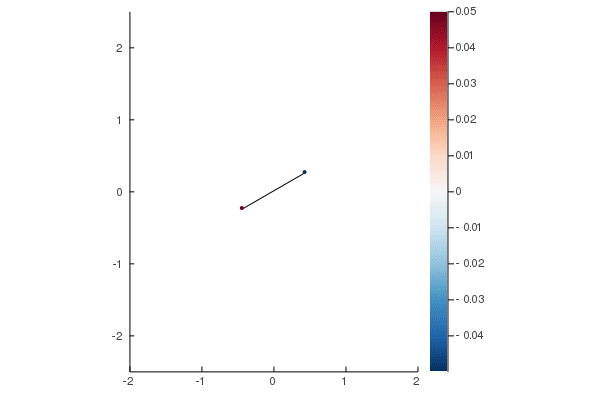

In [36]:
anim = @animate for i = 1:10:1001
    plot(systems[i], color = :RdBu_r, ratio = 1, xlim=(-2.0, 2.0), ylim=(-2.5, 2.5))
end
gif(anim, "flapping_wing_lesp0p6.gif")

In [ ]:
plot(T, [-2real.(forces) 2imag.(forces)], layout = (2,1), linewidth = 2,
     xlabel = "Convective Time", ylabel = ["C_L" "C_D"], ylim = (-25.0, 25.0))

# Analyzing the System with Changes in Critical LESP

#### The critical LESP value stays constant in each simulation, but we vary this constant value to find its effect on the forces acting on the plate.

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0


┌ Info: Saved animation to 
│   fn = C:\Users\nitin\Documents\PotentialFlow.jl-master\PotentialFlow.jl-master\binder\notebooks\forces_actual.gif
└ @ Plots C:\Users\nitin\.julia\packages\Plots\2KhB2\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\nitin\\Documents\\PotentialFlow.jl-master\\PotentialFlow.jl-master\\binder\\notebooks\\forces_actual.gif")
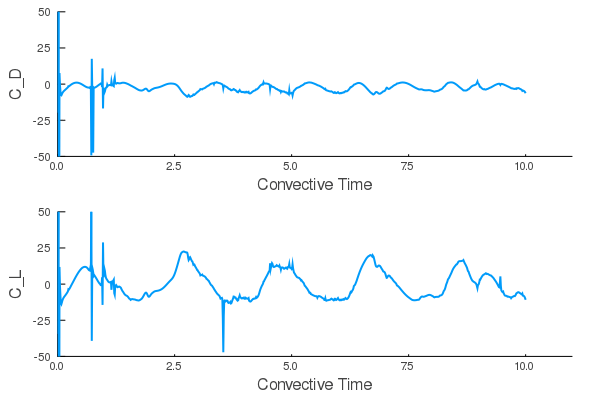

In [18]:
# DONT RUN THIS PART UNLESS YOUR REALLY WANT TO

Δt = 0.01
T = 0.0:Δt:10.0


newanim = @animate for lesp = 0.0:0.1:5.0 # 0:0.01:2
    
    N = 128
    L = 1.0 # length of plate
    plate = Plate(N, L, zero(ComplexF64), oscil.α(0))

    δ = 0.01
    tesp = 0.0

    Δz₀ = im*3Δt*exp(im*plate.α)
    z₋, z₊ = plate.zs[[1,N]]
    
    blobs = Vortex.Blob.(Δz₀ .+ [z₊, z₋], 1.0, δ)
    
    println(lesp)

    Plates.enforce_no_flow_through!(plate, motion, (), 0)
    Γ₊, Γ₋, _, _ = Plates.vorticity_flux!(plate, blobs[1], blobs[2], 0.0, lesp, tesp);

    blobs = Vortex.Blob.(Δz₀ .+ [z₊, z₋], [Γ₊, Γ₋], δ)

    sys₀ = (plate, blobs)

    sys = deepcopy(sys₀)
    sys₊ = deepcopy(sys₀) # Used for storage during time-marching
    ẋs = (motion, allocate_velocity(blobs))

    forces = ComplexF64[];
    
    systems = Tuple{Plate,Array{PotentialFlow.Blobs.Blob{Float64},1}}[];

    for t in T

        plate, ambient_ω = sys
        motion, ambient_u = ẋs

        resize!(sys₊[2], length(sys[2]))
        forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)

        # The force requires information about the motion of the plate,
        # the strength, location, and velocity of the ambient vortex elements,
        # as well as the vorticity flux from the plate edges
        push!(forces, Plates.force(plate, motion, ambient_ω, ambient_u,
                (ambient_ω[end-1], ambient_ω[end]), Δt))

        sys, sys₊ = sys₊, sys
        sys_new = deepcopy(sys)
        push!(systems, sys_new)

        shed_new_vorticity!(sys[2], sys[1], ẋs[1], t, lesp, tesp)
    end
    
    plot(T, [-2real.(forces) 2imag.(forces)], layout = (2,1), linewidth = 2, xlim=(0.0, 11.0), ylim=(-50.0, 50.0),
     xlabel = "Convective Time", ylabel = ["C_D" "C_L"])
    
end

gif(newanim, "forces_actual.gif")